# EAS 560 Summer project 
## Multi-Layer Perceptron
---
This notebook is for the summer project of EAS 560. MLP model is setup to predict Total Phosphorus (TP) concentration from Genesee River basin to Lake Ontario.

The process will be broken down into the following steps:
>1. Load and preprocessing (normalization, set training, validation and test data set)
3. Define a neural network
4. Train the model
5. Evaluate the performance of our trained model on a test dataset!

In [1]:
# import libraries
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

---
###  Load and Preprocess the Data


In [2]:
# convert data to torch.FloatTensor
#transform = transforms.ToTensor()

# choose the training, validation and test datasets
# load xlsx file 
### **NOTE: MORE PORPOTENTIAL FEATURES COULD BE ADDED FROM POINT SOURCE**
data = pd.read_excel("average_input.xlsx")
target = pd.read_excel("input_data.xlsx",sheet_name='target')

In [3]:
# I standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.
# The scaling factors are saved so we can go backwards when we use the network for predictions.
quant_features = [i for i in data.columns][1:]
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [4]:
data

,date,water_temp(main),mian_stem_discharge(fts),Canaseraga_discharge(fts),Oatka_discharge(fts),Honeoye_discharge(fts),Black_Creeks_dischage(fts),Upper_Genesee_River_discharge(fts)),Canaseraga_TP_conc(mg/l),Oatka_TP_conc(mg/l),Honeoye_TP_conc(mg/l),Black_Creeks_TP_conc(mg/l),Upper_Genesee_River_TP_conc(mg/l),precipitation_average,2day_precip_average,7day_precip_average,temp_max_average,temp_min_average,canal_TP(kg),PTS_TPkg
0,2008-01-01,-0.854470,-1.400244,-0.801298,-0.889820,-0.941407,-1.020177,-0.891947,-0.497205,-1.298222,0.333622,-0.800188,-0.367367,0.000277,-0.323953,-0.804568,-0.941519,-0.735441,-0.860801,0.999863
1,2008-01-02,-1.248379,-1.400007,-0.800721,-0.888075,-0.860073,-1.020177,-0.891909,10.663069,10.888305,0.377610,-0.800188,-0.367367,-0.228151,-0.149859,-0.804568,-1.256473,-1.494289,-0.860801,0.999863
2,2008-01-03,-2.084777,-1.399686,-0.800125,-0.888320,-0.803272,-1.020178,-0.891866,8.907670,15.183182,0.435826,-0.800188,-0.367367,-0.420321,-0.426501,-0.804568,-1.751402,-2.144730,-0.860801,0.999863
3,2008-01-04,-1.543153,-1.399298,-0.799507,-0.887706,-0.766380,-1.020177,-0.891822,7.683892,16.772087,0.632078,-0.800188,-0.367367,-0.492838,-0.600595,-0.804568,-1.346461,-1.385882,-0.860801,0.999863
4,2008-01-05,-1.445070,-1.398859,-0.798891,-0.887625,-0.743687,-1.020176,-0.891771,6.890881,17.477230,9.758432,-0.800188,-0.367367,-0.474709,-0.636368,-0.804568,-0.806538,-0.789644,-0.860801,0.999863
5,2008-01-06,-0.410667,-1.398350,-0.798311,-0.877162,-0.729602,-1.020173,-0.891685,6.370381,13.357951,0.124392,-0.800188,5.069383,-0.347804,-0.540974,-0.804568,-0.356603,-0.085000,-0.860801,0.999863
6,2008-01-07,0.180195,-1.397829,-0.797777,-0.740078,-0.723440,-1.020169,-0.891399,5.931097,5.371998,1.331114,-0.800188,30.981211,-0.456579,-0.529050,-0.804568,0.228313,0.565441,-0.860801,0.999863
7,2008-01-08,0.823579,-1.397294,-0.797281,-0.512150,-0.721155,-1.020164,-0.891116,5.450433,1.737292,0.734085,-0.800188,0.660387,-0.347804,-0.529050,-0.920325,0.543268,1.107475,-0.860801,0.999863
8,2008-01-09,0.377149,-1.396752,-0.796096,0.007938,-0.720584,-1.020158,-0.890494,21.920546,0.526421,9.154320,-0.800188,8.131143,0.087297,-0.171323,-0.815421,0.543268,-0.030796,-0.860801,0.999863
9,2008-01-10,-0.607621,-1.396209,-0.795373,-0.579358,-0.715194,-1.020151,-0.889808,3.419453,2.461767,6.132145,-0.800188,7.397598,-0.028730,0.038544,-0.685195,-0.671558,-0.518627,-0.860801,0.999863


In [5]:
#t_mean,t_std=target['mian TP conc(mg/l)'].mean(),target['mian TP conc(mg/l)'].std()
#target=(target-t_mean)/t_std


In [6]:
# percentage of training set to use as validation
train_size = 0.6
valid_size = 0.2


# obtain training, validation and test indices
num_data = len(data)
indices = list(range(num_data))

np.random.seed(0)
np.random.shuffle(indices)
split1 = int(np.floor(train_size * num_data))
split2 = int(np.floor((train_size+valid_size) * num_data))
train_idx, valid_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

# get training, validation and test datasets
train_x = data.loc[train_idx,:]
valid_x = data.loc[valid_idx,:]
test_x = data.loc[test_idx,:]

In [7]:
# Divide target into training, validation and test datasets
train_y = target.iloc[train_idx,:]
valid_y = target.iloc[valid_idx,:]
test_y = target.iloc[test_idx,:]

In [8]:
train_set = TensorDataset(torch.from_numpy(train_x.iloc[:,1:].values), torch.from_numpy(train_y.values))
valid_set = TensorDataset(torch.from_numpy(valid_x.iloc[:,1:].values), torch.from_numpy(valid_y.values))
test_set = TensorDataset(torch.from_numpy(test_x.iloc[:,1:].values), torch.from_numpy(test_y.values))

In [9]:
batch_size=16
train_loader = DataLoader(train_set, batch_size=batch_size)
valid_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [10]:
# Pandas dataframe to tensor
#train_xtensor=torch.Tensor(train_x.drop(columns=['date']).values)
#valid_xtensor=torch.Tensor(valid_x.drop(columns=['date']).values)
#test_xtensor=torch.Tensor(test_x.drop(columns=['date']).values)

#train_ytensor=torch.Tensor(train_y.values)
#valid_ytensor=torch.Tensor(valid_y.values)
#test_ytensor=torch.Tensor(test_y.values)

In [11]:
dataiter = iter(train_loader)
feature, labels = dataiter.next()
labels.shape


torch.Size([16, 1])

---
### Define the Network Architecture

The architecture will be responsible for seeing as input a 33-dim Tensor, and producing a Tensor of length 1 that indicates the TP for input data. This particular example uses one hidden layers and dropout to avoid overfitting.

Some futrue scenarios for hyperparameter turning:
>1. Number of hidden layers (1, 2, 3)
2. Number of Neurons (5 to 60)
2. Activiation functions (ReLU, ELU, Tanh)
3. Optimizer (SGD, RMSprop, Adam)
4. Batch size (8,16,32,64,128)
5. Drop out fraction (0.2, 0.4, 0.6)
6. Learning rates (0.01, 0.05)
7. Number of epoch (20, 30, 40, 50)

This setting use:
>1. **2** hidden layer; 
2. **32,16** neurons; 
3. **ReLU** activation functions;
4. **SGD** optimizer; 
5. **8** batch size; 
6. **0.2** dropout fraction.
7. **0.005** learning rate
8. **20** epoch number

Further action:
>1. initial weights
2. take batches
3. feature selection, add PS and NPS
4. use R2
4. Batch normalization

In [12]:
import torch.nn as nn
import torch.nn.functional as F

feature_num=feature.size(1)

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        hidden_1=10
        hidden_2=16
        # linear layer (33 -> hidden node1)
        self.fc1 = nn.Linear(feature_num, hidden_1)
        # linear layer (hidden node1 -> hidden node2)
        #self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (hidden node2 -> 1)
        self.fc3 = nn.Linear(hidden_1, 1)
        ##dropout
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, feature_num)
        # add hidden layer, with relu activation function
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc3(x)
        #x = self.dropout(x)
        #x = F.relu(self.fc3(x))
        return x

# initialize the NN
#model = Net()
#print(model)

In [13]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# create a new model with these weights
model = Net()
model.apply(weights_init_uniform_rule)

Net(
  (fc1): Linear(in_features=19, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [14]:
## TODO: Specify loss and optimization functions
import torch.optim as optim
# specify loss function
criterion = nn.MSELoss()

# specify optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.005)


---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [15]:
# number of epochs to train the model
n_epochs = 100 
valid_loss_min = np.Inf # set initial "min" to infinity

model.train() # prep model for training

train_loss_list=[]
valid_loss_list=[]
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    #valid_predict=[]
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        #valid_predict.append(np.squeeze(output.detach().numpy()))
        # calculate the loss
        loss = criterion(output, target.float())
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)    
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/train_x.shape[0]
    valid_loss = valid_loss/valid_x.shape[0]

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.029373 	Validation Loss: 0.005315
Validation loss decreased (inf --> 0.005315).  Saving model ...
Epoch: 2 	Training Loss: 0.024788 	Validation Loss: 0.004906
Validation loss decreased (0.005315 --> 0.004906).  Saving model ...
Epoch: 3 	Training Loss: 0.023522 	Validation Loss: 0.004924
Epoch: 4 	Training Loss: 0.022600 	Validation Loss: 0.005342
Epoch: 5 	Training Loss: 0.021863 	Validation Loss: 0.005922
Epoch: 6 	Training Loss: 0.021191 	Validation Loss: 0.006441
Epoch: 7 	Training Loss: 0.020552 	Validation Loss: 0.007164
Epoch: 8 	Training Loss: 0.020038 	Validation Loss: 0.007968
Epoch: 9 	Training Loss: 0.019578 	Validation Loss: 0.008368
Epoch: 10 	Training Loss: 0.019135 	Validation Loss: 0.009151
Epoch: 11 	Training Loss: 0.018735 	Validation Loss: 0.009983
Epoch: 12 	Training Loss: 0.018358 	Validation Loss: 0.010861
Epoch: 13 	Training Loss: 0.018071 	Validation Loss: 0.012034
Epoch: 14 	Training Loss: 0.017718 	Validation Loss: 0.013269
Epoch: 1

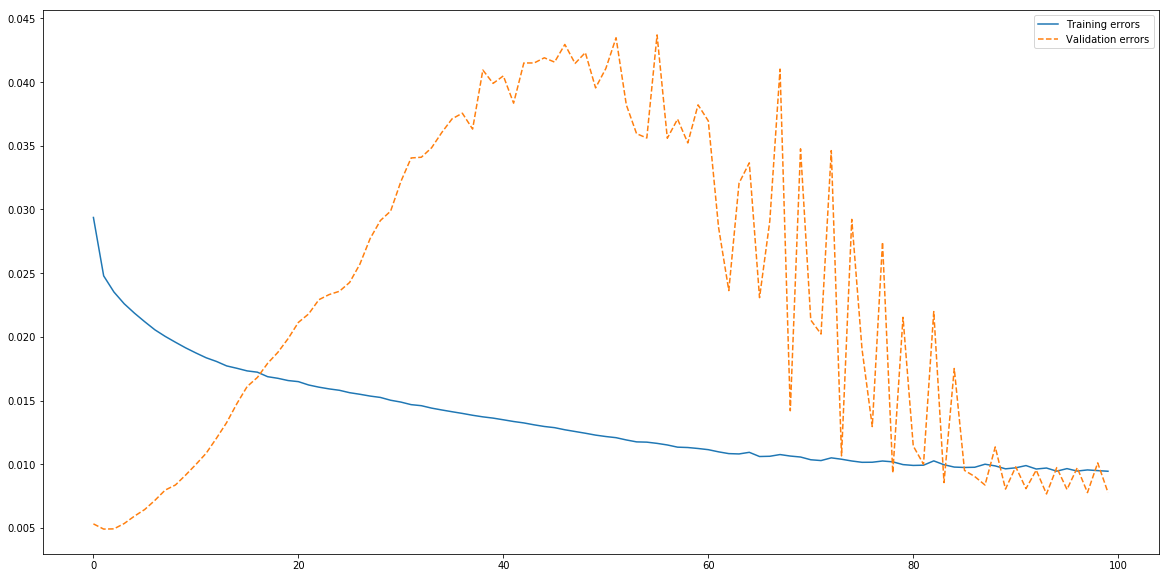

In [16]:
##plot out the training and validation loss with epochs

plt.figure(figsize=(20,10))
x_axis=range(n_epochs)
plt.plot(x_axis,train_loss_list,label="Training errors")
plt.plot(x_axis,valid_loss_list,label="Validation errors",linestyle='dashed')
plt.legend()

In [17]:
###  Load the Model with the Lowest Validation Loss

In [18]:
model.load_state_dict(torch.load('model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [19]:
############################################      
# get validation prediction from the best model #
############################################  
model.eval() # prep model for evaluation
valid_predict=[]
for data, target in valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    
    valid_predict.append(output.detach().numpy())

In [20]:
valid=[]
for i in valid_predict:
    for j in i:
        valid.append(float(j))

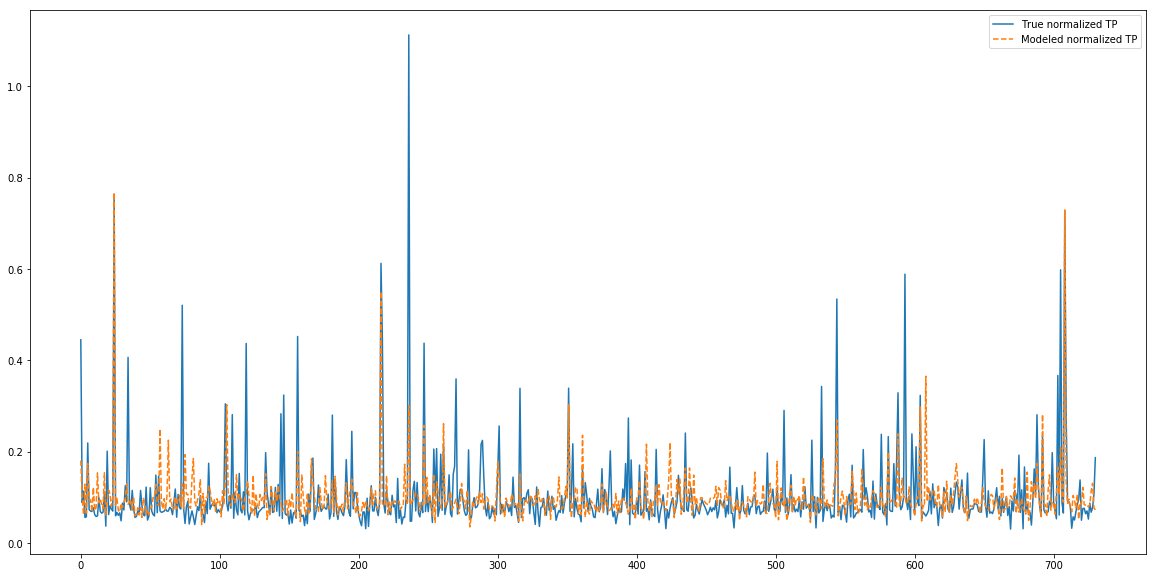

In [21]:
##plot out the series of true and prediction for validation data

valid_ylist=list(np.squeeze(valid_y.values))

plt.figure(figsize=(20,10))
x_valid=range(len(valid_ylist))
plt.plot(x_valid,valid_ylist,label="True normalized TP")
plt.plot(x_valid,valid,label="Modeled normalized TP",linestyle='dashed')
plt.legend()
#plt.ylim(0,0.5)

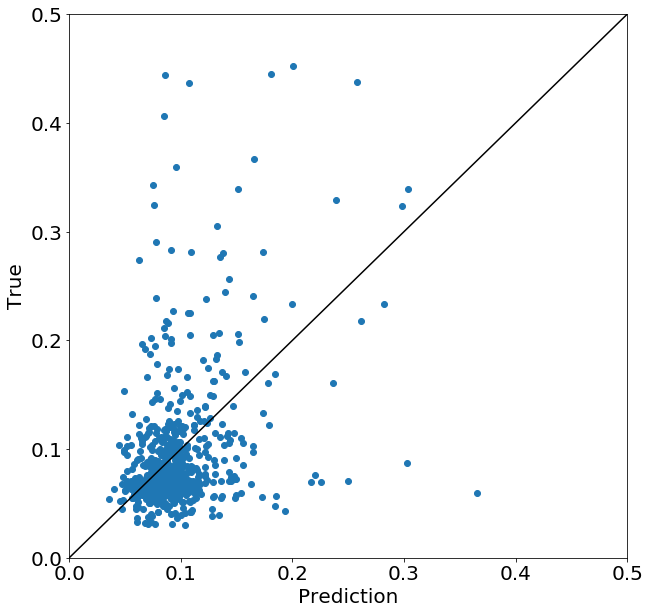

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(valid,valid_ylist)
plt.plot([0,1],[0,1],color='black')
plt.ylim([0,0.5])
plt.xlim([0,0.5])
plt.xlabel('Prediction',fontsize=20)
plt.ylabel('True',fontsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.tick_params(axis="x", labelsize=20)

In [23]:
valid=np.array(valid)
mean_pred, std_pred = np.mean(valid), np.std(valid)
valid_pred=list((valid-mean_pred)/std_pred)

valid_ylist=np.array(valid_ylist)
mean_true, std_true = np.mean(valid_ylist), np.std(valid_ylist)
valid_ylist2=list((valid_ylist-mean_true)/std_true)

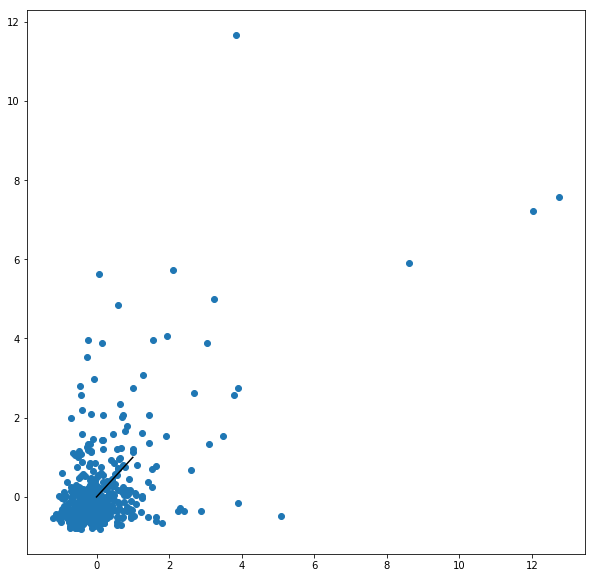

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(valid_pred,valid_ylist2)
plt.plot([0,1],[0,1],color='black')
#plt.ylim([-1,1])
#plt.xlim([-1,1])

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [35]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
#class_correct = list(0. for i in range(10))
#class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*
test_predict=[]
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    test_predict.append(output.detach().numpy())
    # calculate the loss
    loss = criterion(output, target.float())
    # update test loss 
    test_loss += loss.item()*data.size(0)

# calculate and print avg test loss
test_loss = test_loss/test_x.shape[0]
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.010474



In [24]:
test=[]
for i in test_predict:
    for j in i:
        test.append(float(j))

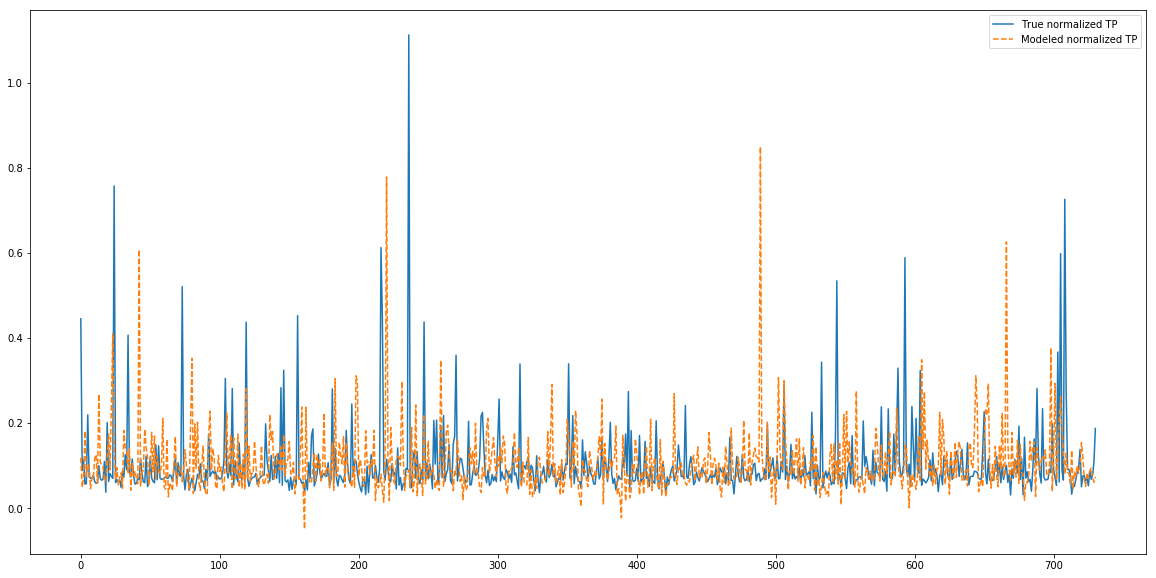

In [25]:
##plot out the series of true and prediction for test data

test_ylist=list(np.squeeze(valid_y.values))

plt.figure(figsize=(20,10))
x_test=range(len(test_ylist))
plt.plot(x_test,test_ylist,label="True normalized TP")
plt.plot(x_test,test,label="Modeled normalized TP",linestyle='dashed')
plt.legend()
#plt.ylim(0,0.5)

### Calculate R2



In [26]:
from sklearn.metrics import r2_score

In [27]:
r2_score(test_ylist, test)

-0.6904374059353524

In [28]:
len(test_ylist)

731

### Plot Hyperparameter tests

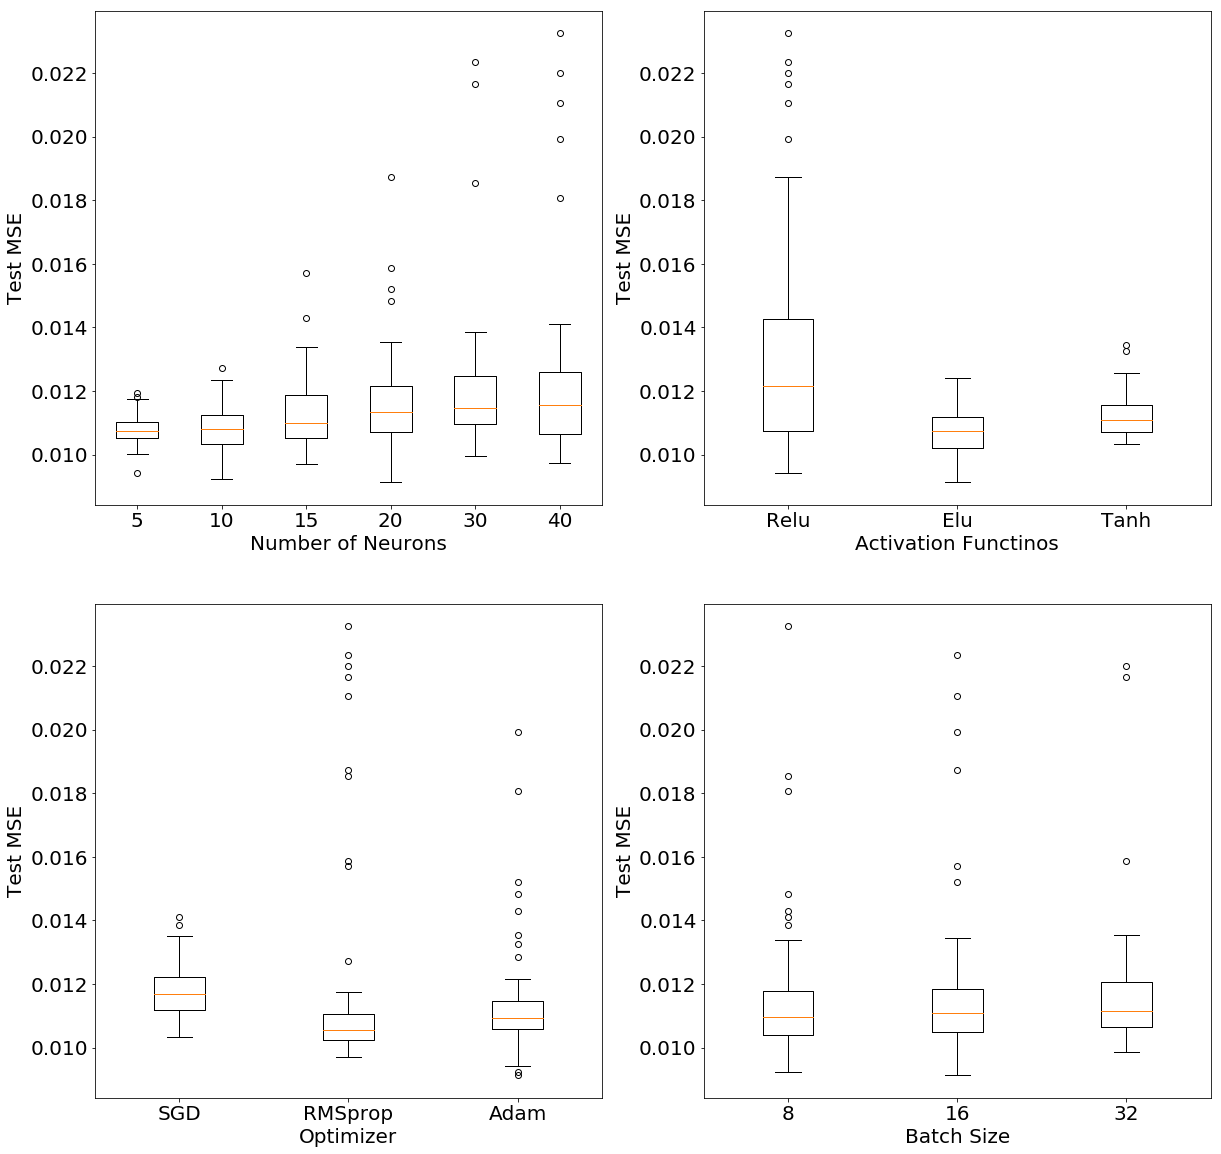

In [59]:
error_df=pd.read_excel("error_average.xlsx")
neuron_5=error_df[error_df['neuron_num']==5]['test_loss'].values
neuron_10=error_df[error_df['neuron_num']==10]['test_loss'].values
neuron_15=error_df[error_df['neuron_num']==15]['test_loss'].values
neuron_20=error_df[error_df['neuron_num']==20]['test_loss'].values
neuron_30=error_df[error_df['neuron_num']==30]['test_loss'].values
neuron_40=error_df[error_df['neuron_num']==40]['test_loss'].values


active_relu=error_df[error_df['activation']=='relu']['test_loss'].values
active_elu=error_df[error_df['activation']=='elu']['test_loss'].values
active_tanh=error_df[error_df['activation']=='tanh']['test_loss'].values


optimizer_SGD=error_df[error_df['optimizer']=='SGD']['test_loss'].values
optimizer_RMSprop=error_df[error_df['optimizer']=='RMSprop']['test_loss'].values
optimizer_Adam=error_df[error_df['optimizer']=='Adam']['test_loss'].values


batch_8=error_df[error_df['batch']==8]['test_loss'].values
batch_16=error_df[error_df['batch']==16]['test_loss'].values
batch_32=error_df[error_df['batch']==32]['test_loss'].values

fig, (ax1, ax2) = plt.subplots(2,2,figsize=(20,20))
collection_neuron=[neuron_5,neuron_10,neuron_15, neuron_20, neuron_30, neuron_40]
ax1[0].boxplot(collection_neuron)
ax1[0].set_xticklabels(['5', '10', '15', '20', '30', '40'],fontsize = 20.0)
ax1[0].set_xlabel('Number of Neurons',fontsize = 20.0)
ax1[0].set_ylabel('Test MSE',fontsize = 20.0)
ax1[0].tick_params(axis="y", labelsize=20)

collection_activation=[active_relu,active_elu,active_tanh]
ax1[1].boxplot(collection_activation)
ax1[1].set_xticklabels(['Relu', 'Elu', 'Tanh'],fontsize = 20.0)
ax1[1].set_xlabel('Activation Functinos',fontsize = 20.0)
ax1[1].set_ylabel('Test MSE',fontsize = 20.0)
ax1[1].tick_params(axis="y", labelsize=20)

collection_optimizer=[optimizer_SGD,optimizer_RMSprop,optimizer_Adam]
ax2[0].boxplot(collection_optimizer)
ax2[0].set_xticklabels(['SGD', 'RMSprop', 'Adam'],fontsize = 20.0)
ax2[0].set_xlabel('Optimizer',fontsize = 20.0)
ax2[0].set_ylabel('Test MSE',fontsize = 20.0)
ax2[0].tick_params(axis="y", labelsize=20)

collection_batch=[batch_8,batch_16,batch_32]
ax2[1].boxplot(collection_batch)
ax2[1].set_xticklabels(['8', '16', '32'],fontsize = 20.0)
ax2[1].set_xlabel('Batch Size',fontsize = 20.0)
ax2[1].set_ylabel('Test MSE',fontsize = 20.0)
ax2[1].tick_params(axis="y", labelsize=20)

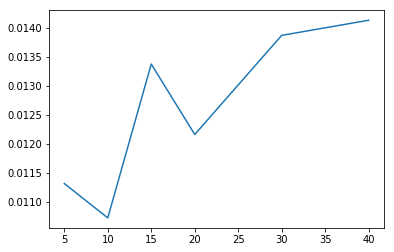

In [29]:
neuron_num=[5, 10, 15, 20, 30, 40]
test_loss=[0.011318, 0.010727, 0.013372, 0.012161, 0.013865, 0.014125]
plt.plot(neuron_num,test_loss)